In [2]:
#импортируем библиотеки
import pandas as pd
import datetime 
import numpy as np 
import ydata_profiling
import matplotlib.pyplot as plt
import matplotlib_inline
%matplotlib inline

In [3]:
df = pd.read_csv('RFM_data.csv', sep=';')
df

,CustomerID,SalesOrderNumber,SalesAmount,OrderDate
0,15084,SO54147,2419.0600,2020-03-09
1,14522,SO66951,53.9900,2020-09-24
2,16190,SO72219,71.9700,2020-12-03
3,21225,SO47141,2181.5625,2019-02-06
4,12188,SO54173,2354.9800,2020-03-10
...,...,...,...,...
27654,14156,SO70784,195.5900,2020-11-14
27655,21843,SO55776,13.9800,2020-04-06
27656,25305,SO56134,1725.9800,2020-04-13
27657,20599,SO64144,32.2700,2020-08-13


In [4]:
df.columns

Index(['CustomerID', 'SalesOrderNumber', 'SalesAmount', 'OrderDate'], dtype='object')

In [6]:
df.rename(columns={
    'CustomerID':'customer_id',
    'SalesOrderNumber':'order_id',
    'SalesAmount':'sale_amount',
    'OrderDate':'order_date'
}, inplace=True)

In [7]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27659 entries, 0 to 27658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  27659 non-null  int64  
 1   order_id     27659 non-null  object 
 2   sale_amount  27659 non-null  float64
 3   order_date   27659 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 864.5+ KB


In [10]:
#приводим дату в формат даты
df.order_date = pd.to_datetime(df.order_date, format="%Y-%m-%d", errors='coerce')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27659 entries, 0 to 27658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  27659 non-null  int64         
 1   order_id     27659 non-null  object        
 2   sale_amount  27659 non-null  float64       
 3   order_date   27657 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 864.5+ KB


In [14]:
#добавляем настоящую дату или дату, с которой нас интересует длительность с последней покупки клиентов
present_date = datetime.datetime(year=2023, month=11, day=7, hour=19, minute=00, second=00)

* Recency (R), давность покупок или действий клиента
* Frequency (F), частота покупок или действий клиента
* Monetary (M), денежная ценность покупок или действий клиента для компании

In [15]:
rfm = df.groupby('customer_id').agg({
    'order_date': lambda date: (present_date - date.max()).days,
    'order_id': lambda num: len(num.unique()),
    'sale_amount': lambda price: price.sum()
})

In [16]:
rfm

,order_date,order_id,sale_amount
customer_id,,,
11000,1283,3,8248.9900
11001,1062,3,6383.8800
11002,1353,3,8114.0400
11003,1276,3,8139.2900
11004,1285,3,8196.0100
...,...,...,...
29479,1525,1,2049.0982
29480,1208,1,2442.0300
29481,1912,1,3374.9900


In [17]:
rfm.columns=['recency','frequency','monetary']

In [18]:
rfm

,recency,frequency,monetary
customer_id,,,
11000,1283,3,8248.9900
11001,1062,3,6383.8800
11002,1353,3,8114.0400
11003,1276,3,8139.2900
11004,1285,3,8196.0100
...,...,...,...
29479,1525,1,2049.0982
29480,1208,1,2442.0300
29481,1912,1,3374.9900


Мы посчитали R,F,M метрики для каждого клиента в нашем датасете и получили датасет rfm. Теперь необходимо каждую метрику сегментировать, т.е. поделить в ней значения на 4 части по интервалам значений. Для деления значений по интервалам используем квантили

* 0.25 квантиль - первый квартиль
* 0.5 квантиль - медианное значение
* 0.75 квантиль - третий квартиль

In [25]:
quartiles = rfm.quantile(q=[0.25, 0.50, 0.75])
print(quartiles, type(quartiles))

      recency  frequency  monetary
0.25   1099.0        1.0    49.970
0.50   1181.0        1.0   270.265
0.75   1276.0        2.0  2511.275 <class 'pandas.core.frame.DataFrame'>


In [26]:
quartiles=quartiles.to_dict()
pd.DataFrame(quartiles)

,recency,frequency,monetary
0.25,1099.0,1.0,49.970
0.50,1181.0,1.0,270.265
0.75,1276.0,2.0,2511.275


In [29]:
#создаем функцию для определения сегмента по метрике Recency (R)
#чем меньше дней в R, тем меньше давность покупки клиента - это хорошо (присваем 4 класс) 
#чем больше дней в R, тем больше давность (клиент делал покупку давно) - это плохо (присваеваем 1)
def R_class(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [30]:
#создаем функцию для определения сегмента по метрикам Frequency (F) и Monetary (M)
#чем меньше значение, тем хуже (присваеваем 1 класс)
#чем выше значение этих метрик, тем лучше (присваем 4 класс)

def FM_class(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
       return 3
    else:
        return 4

In [32]:
#применяем написанные функции к датафрейму rfm для присвоения классов

#копируем датафрейм с другим именем 
rfm_seg = rfm

#создаем новые столбцы, где будут указаны классы для каждого клиента по R,F,M метрикам
rfm_seg['R'] = rfm_seg['recency'].apply(R_class, args=('recency',quartiles,))
rfm_seg['F'] = rfm_seg['frequency'].apply(FM_class, args=('frequency',quartiles,))
rfm_seg['M'] = rfm_seg['monetary'].apply(FM_class, args=('monetary',quartiles,))

In [33]:
rfm_seg

,recency,frequency,monetary,R,F,M
customer_id,,,,,,
11000,1283,3,8248.9900,1,4,4
11001,1062,3,6383.8800,4,4,4
11002,1353,3,8114.0400,1,4,4
11003,1276,3,8139.2900,2,4,4
11004,1285,3,8196.0100,1,4,4
...,...,...,...,...,...,...
29479,1525,1,2049.0982,1,1,3
29480,1208,1,2442.0300,2,1,3
29481,1912,1,3374.9900,1,1,4


In [36]:
# построение таблицы сегментации клиентов по классам
mon_pivot_table = rfm_seg.pivot_table(index='F', columns='R', values='monetary', aggfunc=np.mean)

In [37]:
mon_pivot_table

R,1,2,3,4
F,,,,
1,790.682260,449.808431,468.398097,555.608008
3,3795.083456,3139.127876,2758.979362,2278.872009
4,5432.720208,6250.117804,5050.340385,3624.366971


In [38]:
import seaborn as sns

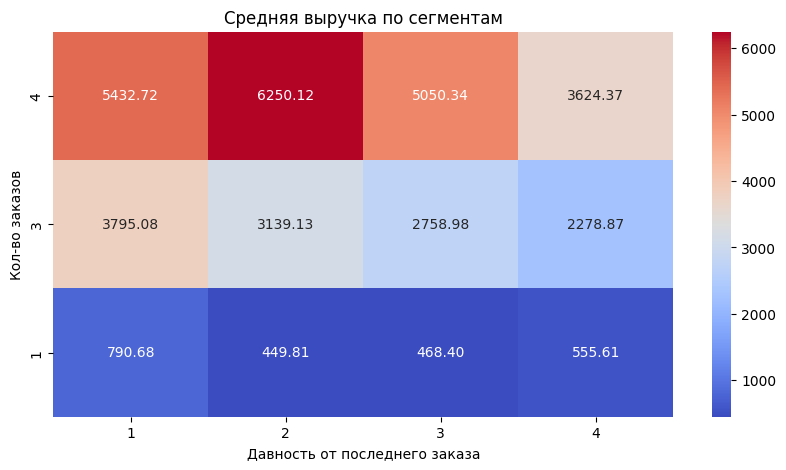

In [40]:
plt.figure(figsize=(10,5))
sns.heatmap(mon_pivot_table, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Средняя выручка по сегментам')
plt.xlabel('Давность от последнего заказа')
plt.ylabel('Кол-во заказов')
plt.gca().invert_yaxis()
plt.show()

 * 11,13,21,23 - нелояльные клиенты или уже потерянные (заказывают редко и давно была покупка)
 * 
14,24 - клиенты на грани потери (заказывали часто, приносили много денег, но давно) * 

31,33,41,43 - перспективные клиенты (покупки были не так давно, можно попробывать привлечь их сделать лояльным * и)

34,44 - лояльные клиенты (покупают часто и последняя покупка была недавно)

In [41]:
rfm_seg[['frequency', 'F']].drop_duplicates().sort_values('frequency')

,frequency,F
customer_id,,
11015,1,1
11012,2,3
11000,3,4
11237,4,4
11131,5,4
11425,6,4
11241,7,4
11253,16,4
11019,17,4


In [42]:
rfm_seg[rfm_seg.F == 2]

,recency,frequency,monetary,R,F,M
customer_id,,,,,,


In [43]:
#сделаем дополнительное поле чтобы собрать сегменты по RF метрикам
rfm_seg['rf_segment'] = rfm_seg.R.astype(str)+rfm_seg.F.astype(str)

In [44]:
rfm_seg[rfm_seg.rf_segment.isin(['11','13','21','23'])]

,recency,frequency,monetary,R,F,M,rf_segment
customer_id,,,,,,,
11014,1286,2,138.4500,1,3,2,13
11015,1389,1,2500.9700,1,1,3,11
11016,1367,1,2332.2800,1,1,3,11
11020,1409,1,2316.9700,1,1,3,11
11021,1384,1,2371.9600,1,1,3,11
...,...,...,...,...,...,...,...
29479,1525,1,2049.0982,1,1,3,11
29480,1208,1,2442.0300,2,1,3,21
29481,1912,1,3374.9900,1,1,4,11
